# Exploratory Data Analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dython import nominal

In [3]:
leads = pd.read_csv('leads_cleaned.csv', index_col=0)

In [4]:
leads.head()

lead_number                   origin          source  no_email  converted  \
0       660737                      API      Olark Chat         0          0   
1       660728                      API  Organic Search         0          0   
2       660727  Landing Page Submission  Direct Traffic         0          1   
3       660719  Landing Page Submission  Direct Traffic         0          0   
4       660681  Landing Page Submission          Google         0          1   

   visits  visit_time  visit_pages            last_activity  country  ...  \
0     0.0           0          0.0  Page Visited on Website  Unknown  ...   
1     5.0         674          2.5             Email Opened    India  ...   
2     2.0        1532          2.0             Email Opened    India  ...   
3     1.0         305          1.0              Unreachable    India  ...   
4     2.0        1428          1.0        Converted to Lead    India  ...   

              matters_most search recommendations           quality  \
0  Better Career Prospects      0               0  Low in Relevance   
1  Better Career Prospects      0               0           Unknown   
2  Better Career Prospects      0               0          Might be   
3  Better Career Prospects      0               0          Not Sure   
4  Better Career Prospects      0               0          Might be   

          profile     city activity_index profile_index mti_copy  last_notable  
0         Unknown  Unknown              2             2        0      Modified  
1         Unknown  Unknown              2             2        0  Email Opened  
2  Potential Lead   Mumbai              2             3        1  Email Opened  
3         Unknown   Mumbai              2             2        0      Modified  
4         Unknown   Mumbai              2             3        0      Modified  

[5 rows x 23 columns]

## Correlation
Let's check for correlation among all of our columns. We'll use nominal from the dython package, which calculates and plots correlations using Pearson's R for two continuous variables, Correlation Ratio for continuous-categorical, and we'll choose Theil's U for categorical-categorical.

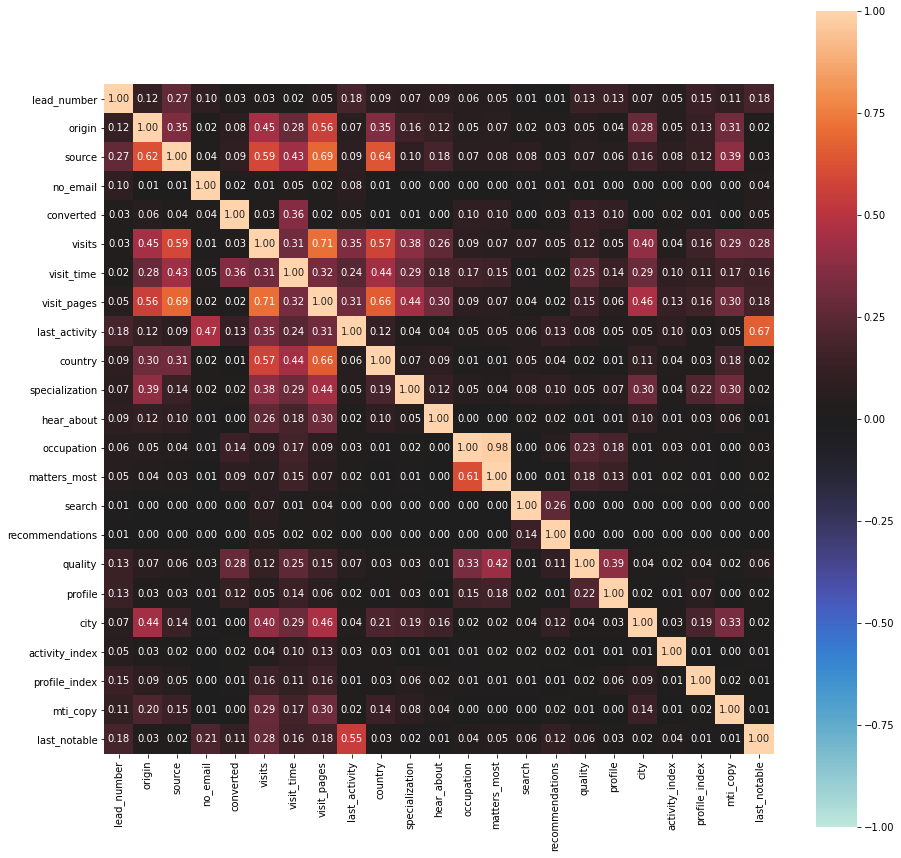

In [5]:
numerical_cols = ['lead_number', 'visits', 'visit_time', 'visit_pages']
nom_cols = [col for col in leads.columns if col not in numerical_cols]

heatmap, corr_df = nominal.associations(leads, nominal_columns=nom_cols, theil_u=True, figsize=(15, 15))

plt.show()

There are many interesting correlations here, let's plot some of the larger ones to see if there are any conclusions to be drawn.

### 1. occupation and matters_most

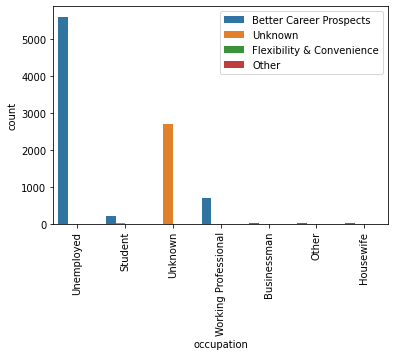

In [6]:
sns.countplot(x='occupation', data=leads, hue='matters_most')
plt.legend(loc=1)
plt.xticks(rotation=90);

It turns out that if the occupation is unknown, then matters_most is also unknown. During the data cleaning phase, we noticed that for matters_most, nearly all values were "Better Career Prospects". However, we kept the column in case there was any significance to the Unknown (NaN) values. Since the occupation column will also be able to predict any relationship between the Unknowns and our target variable, we can safely drop the matters_most column.

In [7]:
leads.drop('matters_most', axis=1, inplace=True)

### 2. visits and visit_pages

<AxesSubplot:xlabel='visits', ylabel='visit_pages'>

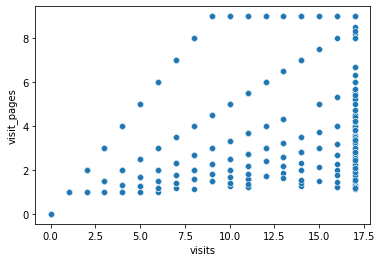

In [8]:
sns.scatterplot(x='visits', y='visit_pages', data=leads)

According to the data dictionary, visits describes "The total number of visits made by the customer on the website" and visit_pages is "Average number of pages on the website viewed during the visits". 

This relationship seems odd-- why should the average number of pages viewed never exceed the number of visits (for example, one visit with 4 pages)? In fact, I would expect the correlation to be negative, since one visit could more easily have a very high or very low number of pages, and more visits would probably keep the average lower (if you visit the site 10 times, it seems unlikely that you'd look at several different pages each time -- some of those visits would be a small number of pages, bringing the average down). 

If it were possible, I would seek to clarify what counts as one 'visit', since it looks like each new page visited counts as a distinct visit, when that should not be the case. But, for the purposes of this project, we will have to ignore this question.

### 3. visit_pages, source, country

visit_pages is also strongly correlated with both source and country. I think there may be two factors in play here. There may be a real difference present, where leads coming from different types of sources interact differently with the website, and leads from different countries tend to come from different sources (depending on which chat/social media/search engine is most popular in that country).

However, I think part of this result is due to both columns having many very small categories, with over half the values in each category containing less than 10 rows, and many with just one or two. When calculating the correlation ratio, it stands to reason that if any examples within these small categories are abnormally far from the overall mean, it will have a big impact on the result.

Let's look at source vs. visit_pages as an example

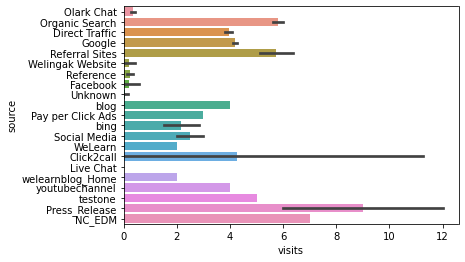

In [9]:
sns.barplot(x='visits', y='source', data=leads, orient='h');

Leads sourced from press releases tend to visit more pages than other sources. One explanation could be that these leads are trying to learn more about the school, but not necessarily for the purpose of enrolling. Conversely, leads coming from various chat services view fewer pages, perhaps because they have already had their questions answered before visiting the website. 

<AxesSubplot:xlabel='visit_pages', ylabel='source'>

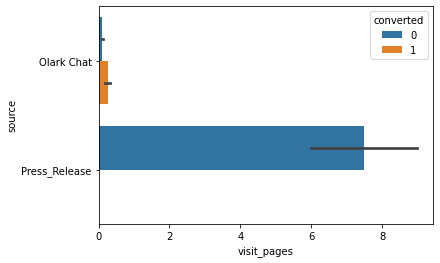

In [10]:
sub_sources = leads[leads.source.isin(['Olark Chat', 'Press_Release'])]
sns.barplot(x='visit_pages', y='source', data=sub_sources, orient='h', hue='converted')

This possible explanation is somewhat supported when we look at the difference in the target variable by source. None of the Press_Release leads converted, while over half of the Olark Chat leads converted. One huge caveat: Press_Release only consists of two leads in our dataset. If one more lead with the source Press_Release ended up converting, or if that lead only viewed 1 page, it would change this graph considerably. It would be interesting to see if there is more data for leads in this category available.

Similar conclusions can be made with the small categories in the country column.

### 4. last_notable and last_activity
These two columns share many category labels, but with different counts. There are also three unique categories in last_activity, and one unique category in last_notable.

In [11]:
np.intersect1d(leads.last_activity, leads.last_notable)

array(['Approached upfront', 'Email Bounced', 'Email Link Clicked',
       'Email Marked Spam', 'Email Opened', 'Email Received',
       'Form Submitted on Website', 'Had a Phone Conversation',
       'Olark Chat Conversation', 'Page Visited on Website',
       'Resubscribed to emails', 'SMS Sent', 'Unreachable',
       'Unsubscribed', 'View in browser link Clicked'], dtype=object)

In [12]:
print(np.setdiff1d(leads.last_activity, leads.last_notable))
print(np.setdiff1d(leads.last_notable, leads.last_activity))

['Converted to Lead' 'Unknown' 'Visited Booth in Tradeshow']
['Modified']


In [13]:
same_last = leads[leads.last_activity == leads.last_notable]
diff_last = leads[leads.last_activity != leads.last_notable]
print(same_last.shape, diff_last.shape)

(5833, 22) (3407, 22)


In [14]:
diff_last.last_notable.value_counts()

Modified    3407
Name: last_notable, dtype: int64

On inspection, it turns out that the only difference between the two columns are the 'Modified' category in last_notable. So, we can simplify the dataset by turning last_notable into a binary column of whether the lead was most recently modified or not.

In [15]:
leads['modified'] = (leads.last_notable=='Modified') * 1
leads.drop('last_notable', axis=1, inplace=True)

## Target Variable
Finally, let's take a look at each of our columns' influence on the target variable. This can give us a first look at which features are important, and which values of a given category appear to be related to a high conversion rate.

In [16]:
def boxplot(column):
    sns.boxplot(y=column, x='converted', data=leads)

def countplot(column):
    sns.countplot(y=column, data=leads, hue='converted')

In [17]:
num_cols = ['lead_number', 'visits', 'visit_time', 'visit_pages', 'converted']
cat_cols = [col for col in leads.columns if col not in num_cols]
num_cols = ['visits', 'visit_time', 'visit_pages']

print(len(num_cols), len(cat_cols))

3 17


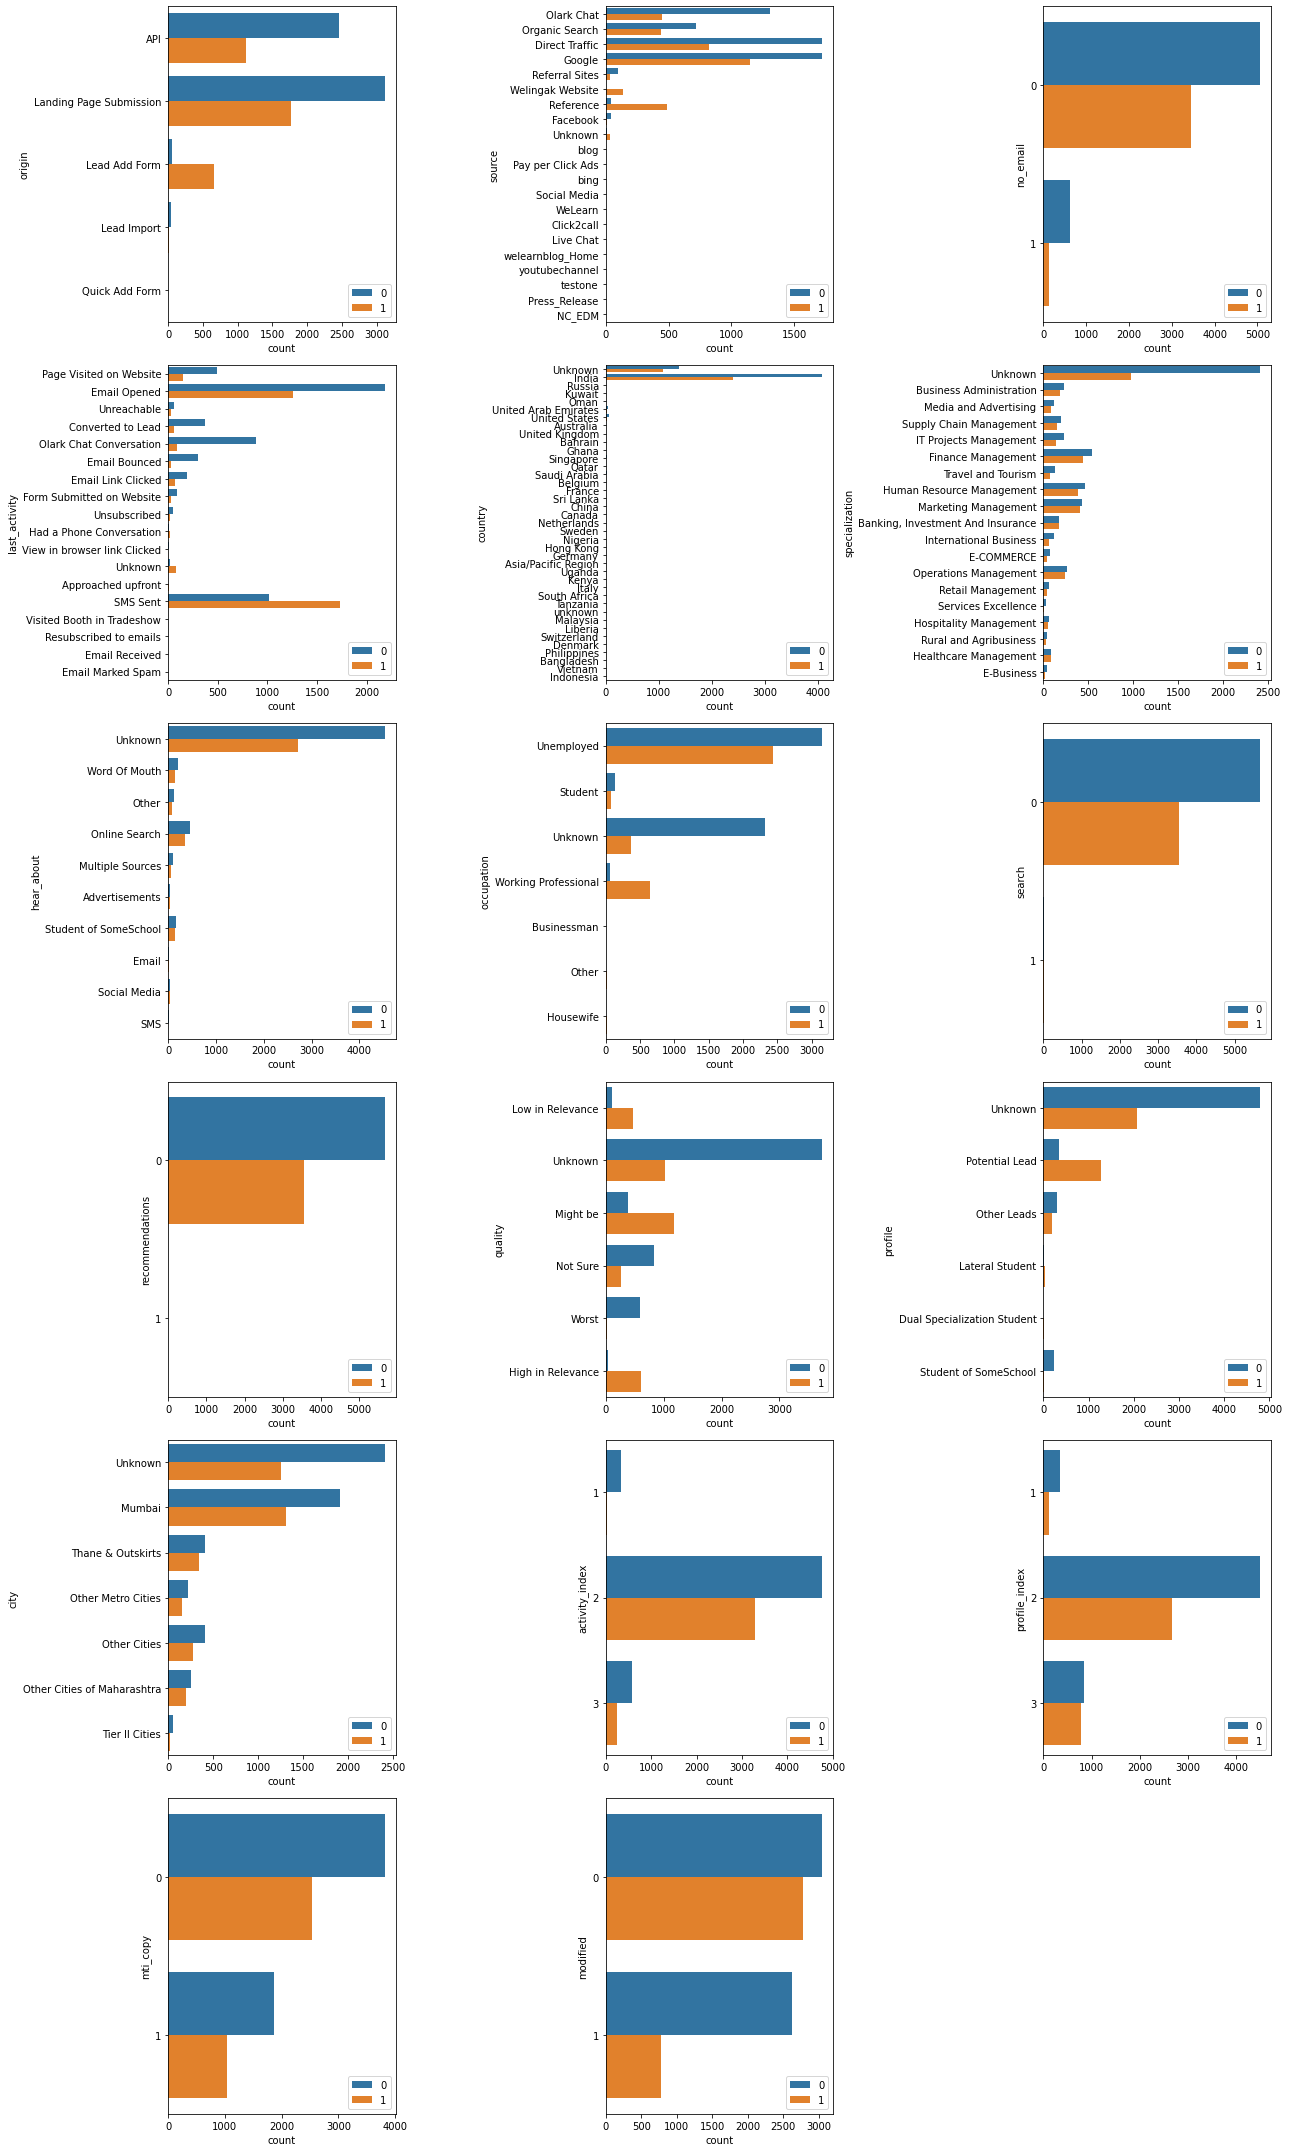

In [18]:
plt.figure(figsize=(18, 30))
s=1
for col in cat_cols:
    plt.subplot(6, 3, s)
    countplot(col)
    plt.legend(loc=4)
    s += 1
plt.tight_layout()
plt.show()

### Observations by Categorical Variable:
(Focus is only on visible differences in larger categories, as big effects in small categories are hard to see in the graphs due to scale.)

* **Origin:** 'Lead Add Form' has much higher conversion
* **Source:** 'Welingak Website', 'Reference', and 'Unknown' have higher conversion
* **Last Activity:** 'SMS Sent' has much higher conversion
* **Occupation:** 'Working Professional has higher conversion
* **Quality:** 'Unknown', 'Not Sure', and 'Worst' have low conversion while the other 3 categories have high conversion
* **Profile:** 'Potential Lead' has good conversion
* **City:** All categories look about the same
* **Activity and Profile Index:** Higher activity index doesn't seem to result in higher conversion, but high profile index does improve conversion a little
* **MTI Copy:** No clear difference between Yes/No
* **Last Notable Action was 'Modified':** When the last notable action was 'Modified', leads were less likely to convert.

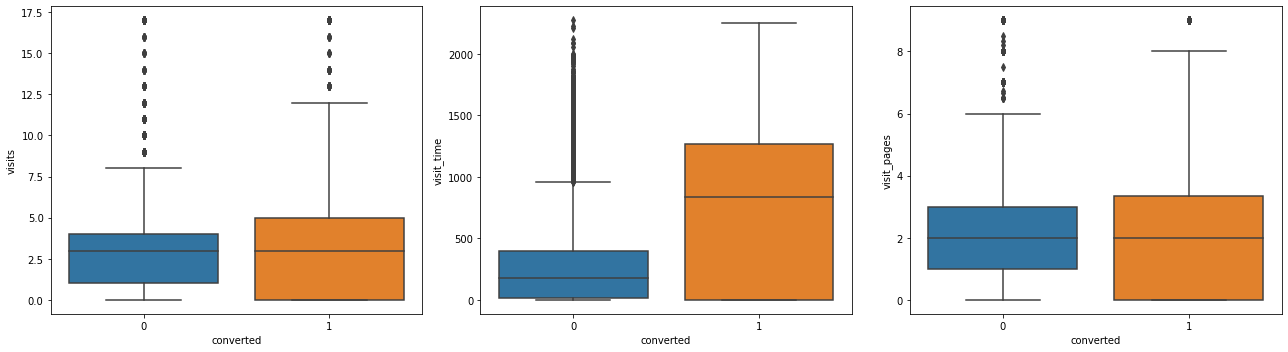

In [19]:
plt.figure(figsize=(18, 5))
s=1
for col in num_cols:
    plt.subplot(1, 3, s)
    boxplot(col)
    s += 1
plt.tight_layout()
plt.show()

### Biggest Takeaways by Numerical Column:
Visits and Pages per Visit have the same median for converted and non-converted, but the non-converted leads tend to stay closer to the mean. Visit Time tends to be higher for converted leads.

I would cautiously say this suggests that if X Education can get potential leads to spend more time on the website, they might be able to increase their conversion rate. There are two important things to remember, though. First, that the directionality of this relationship is not clear (does spending more time on the website make one more likely to convert, or do leads that are more likely to convert tend to spend more time on the website?). Second, if X Education makes a goal of increasing time spent, they should be careful how they achieve it. Making the website harder to use, for example, could result in more time spent but actually have an adverse effect on getting leads to convert.
___

In [20]:
leads.to_csv('leads_cleaned_2.csv')

# Next:
Now that we have a feel for the relationships between features in our dataset, we'll start the modeling process in the next notebook to see if we can use these features for reliable lead scoring.